## Data Preparation For Rebatching



In [152]:
import os
import shutil
import json
import pandas as pd 

import matplotlib.pyplot as plt

In [153]:
data_path = './coded-books/'

In [154]:
def construct_batches_dataframe(data_path):
    """Constructs a dataframe of batches from the data in the given path.
    
    Parameters
    ----------
    data_path : str
        The path to the data.
    
    Returns
    -------
    pandas.DataFrame
        A dataframe of batches. Each row represents a batch. The columns are:
        - ra: The RA who coded the batch.
        - batch: The name of the batch.
        - batch_path: The path to the directory containing the images for the batch.
        - via_json_path: The path to the VIA JSON file for the batch.
    """
    if not os.path.isdir(data_path):
        raise ValueError('data_path must be a directory')
    
    batches = []
    for ra in os.listdir(data_path):
        ra_path = os.path.join(data_path, ra)
        for batch in os.listdir(ra_path):
            batch_path = os.path.join(ra_path, batch)
            json_files = [f for f in os.listdir(batch_path) if f.endswith('.json')]
            if len(json_files) != 1:
                print(f'Found {len(json_files)} JSON files in "{batch_path}". Skipping.')
                continue
            via_json_path = os.path.join(batch_path, json_files[0])
            batches.append({
                'ra': ra,
                'batch': batch,
                'batch_path': batch_path,
                'via_json_path': via_json_path
            })

    return pd.DataFrame(batches)

In [155]:
def validate_via_img_metadata(coded_image):
    """Check that the image metadata in the VIA JSON file has the correct fields.
    
    Parameters
    ----------
    coded_image : dict
        The image metadata from the VIA JSON file.
        
    Returns
    -------
    bool
        True if the metadata is valid, False otherwise.
    """
    if 'filename' not in coded_image:
        return False
    if 'title' not in coded_image['file_attributes']:
        return False
    if 'google' not in coded_image['file_attributes']:
        return False
    if 'identifiable' not in coded_image['file_attributes']:
        return False
    if 'diversity' not in coded_image['file_attributes']:
        return False
    return True 

In [156]:
def construct_coded_images_dataframe(batches_df):
    """Constructs a dataframe of coded images from the given batches dataframe.
    
    Parameters
    ----------
    batches_df : pandas.DataFrame
        A dataframe of batches. Each row represents a batch. The columns are:
        - ra: The RA who coded the batch.
        - batch: The name of the batch.
        - batch_path: The path to the directory containing the images for the batch.
        - via_json_path: The path to the VIA JSON file for the batch.
        
    Returns
    -------
    pandas.DataFrame
        A dataframe of coded images. Each row represents an image. The columns are:
        - ra: The RA who coded the image.
        - batch_path: The path of the batch containing the image.
        - batch_name: The name of the batch containing the image.
        - image: The name of the image.
        - image_path: The path to the image.
        - title: The title of the book.
        - google: The Google Books link for the book.
        - identifiable: Whether the book is identifiable.
        - diversity_none: Whether the image contains no diversity.
        - diversity_bipoc: Whether the image contains diversity in the form of BIPOC.
        - diversity_non_cis_man: Whether the image contains diversity in the form of
                                 non cisgendered man.
        - diversity_lgbq: Whether the image contains diversity in the form of LGBTQ.
        - diversity_non-christian: Whether the image contains diversity in the form of
                                   non-Christian.
        - diversity_disabled: Whether the image contains diversity in the form of
                              disabled.
        - diversity_other: Whether the image contains diversity in the form of other.
        - diversity_ambiguous: Whether the image contains diversity in the form of
                                ambiguous.
    """
    if not set(batches_df.columns) == {'ra', 'batch', 'batch_path', 'via_json_path'}:
        raise ValueError('batches_df must have the columns: ra, batch, batch_path, via_json_path')

    coded_images = []
    for _, row in batches_df.iterrows():
        with open(row['via_json_path'], encoding='utf8') as f:
            via_json = json.load(f)
        for key, coded_image in via_json['_via_img_metadata'].items():
            # TODO: this is very hacky. Should be more elegant about checking valid metadata.
            flag = True
            if not validate_via_img_metadata(coded_image):
                print(f'Invalid metadata for image "{row["via_json_path"]} -> {key}". Writing default.')
                flag = False
            
            if 'filename' not in coded_image:
                print(f'No filename for image "{row["via_json_path"]} -> {key}". No default avaliable. Skipping')
                continue

            ra = row['ra']
            batch_path = row['batch_path']
            batch_name = row['batch']

            image = coded_image['filename']
            image_path = os.path.join(batch_path, image)
            
            title = coded_image['file_attributes']['title'] if flag else ''
            title = title.lower()
        
            google = coded_image['file_attributes']['google'] if flag else ''

            identifiable = coded_image['file_attributes']['identifiable'] if flag else 'no'

            diversity_none = "none" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_bipoc = "bipoc" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_non_cis_man = "non-cis man" in coded_image['file_attributes']['diversity'] if flag else False
            diverseity_lgbq = "lgbq" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_non_christian = "non-christian" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_disabled = "disabled" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_other = "other" in coded_image['file_attributes']['diversity'] if flag else False
            diversity_ambiguous = "ambiguous" in coded_image['file_attributes']['diversity'] if flag else False

            coded_images.append({
                'ra': ra,
                'batch': batch_name,
                'batch_path': batch_path,
                'image': image,
                'image_path': image_path,
                'title': title,
                'google': google,
                'identifiable': identifiable,
                'diversity_none': diversity_none,
                'diversity_bipoc': diversity_bipoc,
                'diversity_non_cis_man': diversity_non_cis_man,
                'diversity_lgbq': diverseity_lgbq,
                'diversity_non_christian': diversity_non_christian,
                'diversity_disabled': diversity_disabled,
                'diversity_other': diversity_other,
                'diversity_ambiguous': diversity_ambiguous
            })

    return pd.DataFrame(coded_images)




In [157]:
batches_df = construct_batches_dataframe(data_path)
coded_images_df = construct_coded_images_dataframe(batches_df)
coded_images_df.head(10)

Found 0 JSON files in "./coded-books/Michelle\Batch 1 training set". Skipping.
Invalid metadata for image "./coded-books/Emily\Batch 10\Emily user 9-2962.json -> user222_3106_book_5_12.jpg5819". Writing default.
Invalid metadata for image "./coded-books/Emily\Batch 10\Emily user 9-2962.json -> user1408_565_book_1_2.jpg8784". Writing default.
Invalid metadata for image "./coded-books/Emily\Batch 3b training set\Emily user46-2995.json -> user2381_2035_book_2_3.jpg4214". Writing default.
Invalid metadata for image "./coded-books/Emily\Batch 8\Emily user 10-2990.json -> user418_468_book_1_11.jpg6023". Writing default.
Invalid metadata for image "./coded-books/Emily\Batch 9\Emily user42-2980.json -> user2180_23_book_7_7.jpg4279". Writing default.
Invalid metadata for image "./coded-books/Michelle\Batch 11\blank_project_template (1).json -> user1218_2954_book_4_3.jpg1718". Writing default.
Invalid metadata for image "./coded-books/Michelle\Batch 11\blank_project_template (1).json -> user2756

,ra,batch,batch_path,image,image_path,title,google,identifiable,diversity_none,diversity_bipoc,diversity_non_cis_man,diversity_lgbq,diversity_non_christian,diversity_disabled,diversity_other,diversity_ambiguous
0,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1433_1806_book_6_9.jpg,./coded-books/Emily\Batch 1 training set\user1...,divergent,https://www.google.com/books/edition/Divergent...,yes,True,False,False,False,False,False,False,False
1,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1433_1806_book_7_10.jpg,./coded-books/Emily\Batch 1 training set\user1...,the book thief,https://www.google.com/books/edition/The_Book_...,yes,True,False,False,False,False,False,False,False
2,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1436_577_book_1_5.jpg,./coded-books/Emily\Batch 1 training set\user1...,pete the cat: five little pumpkins,https://www.google.com/books/edition/Pete_the_...,yes,True,False,False,False,False,False,False,False
3,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1446_3066_book_3_6.jpg,./coded-books/Emily\Batch 1 training set\user1...,lety out loud,https://www.google.com/books/edition/Lety_Out_...,yes,False,True,False,False,False,False,False,False
4,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1446_3066_book_7_10.jpg,./coded-books/Emily\Batch 1 training set\user1...,the bookshop girl,https://www.google.com/books/edition/The_Books...,yes,False,False,False,False,False,False,False,False
5,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1446_3066_book_15_18.jpg,./coded-books/Emily\Batch 1 training set\user1...,power forward,https://www.google.com/books/edition/Power_For...,yes,False,True,False,False,False,False,False,False
6,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1484_3082_book_3_6.jpg,./coded-books/Emily\Batch 1 training set\user1...,smile,https://www.google.com/books/edition/Smile_A_G...,yes,True,False,False,False,False,False,False,False
7,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1492_1233_book_1_5.jpg,./coded-books/Emily\Batch 1 training set\user1...,the great fire,https://www.google.com/books/edition/The_Great...,yes,True,False,False,False,False,False,False,False
8,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1492_1233_book_4_8.jpg,./coded-books/Emily\Batch 1 training set\user1...,night,https://www.google.com/books/edition/Night/8Wx...,yes,True,False,False,False,False,False,False,False
9,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1505_3084_book_4_6.jpg,./coded-books/Emily\Batch 1 training set\user1...,big nate: in a class by himself,https://www.google.com/books/edition/Big_Nate_...,yes,True,False,False,False,False,False,False,False


In [158]:
training_data = coded_images_df[coded_images_df['batch'].str.contains('training')]
non_training_data = coded_images_df[~coded_images_df['batch'].str.contains('training')]

In [159]:
training_data.head()

,ra,batch,batch_path,image,image_path,title,google,identifiable,diversity_none,diversity_bipoc,diversity_non_cis_man,diversity_lgbq,diversity_non_christian,diversity_disabled,diversity_other,diversity_ambiguous
0,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1433_1806_book_6_9.jpg,./coded-books/Emily\Batch 1 training set\user1...,divergent,https://www.google.com/books/edition/Divergent...,yes,True,False,False,False,False,False,False,False
1,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1433_1806_book_7_10.jpg,./coded-books/Emily\Batch 1 training set\user1...,the book thief,https://www.google.com/books/edition/The_Book_...,yes,True,False,False,False,False,False,False,False
2,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1436_577_book_1_5.jpg,./coded-books/Emily\Batch 1 training set\user1...,pete the cat: five little pumpkins,https://www.google.com/books/edition/Pete_the_...,yes,True,False,False,False,False,False,False,False
3,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1446_3066_book_3_6.jpg,./coded-books/Emily\Batch 1 training set\user1...,lety out loud,https://www.google.com/books/edition/Lety_Out_...,yes,False,True,False,False,False,False,False,False
4,Emily,Batch 1 training set,./coded-books/Emily\Batch 1 training set,user1446_3066_book_7_10.jpg,./coded-books/Emily\Batch 1 training set\user1...,the bookshop girl,https://www.google.com/books/edition/The_Books...,yes,False,False,False,False,False,False,False,False


In [160]:
# some images are duplicated across the batches for some reason. This shouldn't have happened.
duplicates_in_non_training= non_training_data[non_training_data['image'].isin(training_data['image'])]
duplicates_in_training = training_data[training_data['image'].isin(non_training_data['image'])]

print(f'Number of non-training duplicates: {len(duplicates_in_non_training)}')
print(f'Number of training duplicates: {len(duplicates_in_training)}')

Number of non-training duplicates: 33
Number of training duplicates: 132


In [161]:
duplicates = pd.concat([duplicates_in_non_training, duplicates_in_training])
duplicates = duplicates.sort_values(by=['image', 'batch'])
duplicates.to_csv('./duplicates.csv', index=False)

In [162]:
# Removing images that were coded with the exact same title by all RA's.
training_data_needs_rebatching = training_data.drop_duplicates(subset=['image', 'title'])

# Removing duplicate images. 
training_data_needs_rebatching = training_data.drop_duplicates(subset=['image'])

In [163]:
non_training_data_needs_rebatching = non_training_data[non_training_data['identifiable'] == 'no']

In [164]:
rebatching_df = pd.concat([training_data_needs_rebatching, non_training_data_needs_rebatching, duplicates_in_non_training], axis=0, ignore_index=True)
rebatching_df = rebatching_df[['ra', 'batch', 'image']]
# There should not have been duplicates in this data, but there were.
# We are going to rebatch all duplicates.
rebatching_df = rebatching_df.drop_duplicates(subset=['image'])
rebatching_df = rebatching_df.rename(columns={'batch': 'old_batch',
                                              'ra': 'old_ra',})
rebatching_df.to_csv('./need-rebatching.csv', index=False)

## Checking Batches for Duplicate Images

In [165]:
batches_path = './batches'

# check all individual directories for duplicate images
for batch in os.listdir(batches_path):
    batch_path = os.path.join(batches_path, batch)
    images = os.listdir(batch_path)
    if len(images) != len(set(images)):
        print(f'batch {batch} has duplicate images.')

# check for duplicate images across all batches
all_images = set()
count = 0
for batch in os.listdir(batches_path):
    batch_path = os.path.join(batches_path, batch)
    batch_images = os.listdir(batch_path)
    for image in batch_images:
        if image in all_images:
            count += 1
            print(f'batch {batch} has duplicate image {image}')
    all_images.update(os.listdir(batch_path))

print(f'Number of duplicate images: {count}')

batch Batch 10 Emily has duplicate image user2078_1971_book_3_8.jpg
batch Batch 11 Michelle has duplicate image user2113_2607_book_1_1.jpg
batch Batch 11 Michelle has duplicate image user2152_2622_book_1_5.jpg
batch Batch 12 Michelle has duplicate image user2276_2006_book_17_16.jpg
batch Batch 13 Stephanie has duplicate image user2219_2002_book_2_5.jpg
batch Batch 14 Stephanie has duplicate image user2156_1995_book_10_11.jpg
batch Batch 15 Stephanie has duplicate image user1446_3066_book_3_6.jpg
batch Batch 15 Stephanie has duplicate image user1980_3831_book_4_4.jpg
batch Batch 15 Stephanie has duplicate image user2281_2010_book_5_15.jpg
batch Batch 18 Sabrina has duplicate image user1484_3082_book_3_6.jpg
batch Batch 19 Sabrina has duplicate image user2036_3841_book_3_12.jpg
batch Batch 20 Nicole has duplicate image user1446_3066_book_15_18.jpg
batch Batch 20 Nicole has duplicate image user1492_1233_book_1_5.jpg
batch Batch 21 Nicole has duplicate image user2133_4504_book_8_8.jpg
batc

## Check for Images That Were Not Coded

In [166]:
# check for images that were not coded 
batches_path = './batches'

all_images = set()
for batch in os.listdir(batches_path):
    batch_path = os.path.join(batches_path, batch)
    batch_images = [file for file in os.listdir(batch_path) if not file.endswith('.json')]
    all_images.update(batch_images)

    coded_images = set(coded_images_df['image'])
    uncoded_images = all_images - coded_images

print(uncoded_images)



set()


## Gathering Images That Need Rebatching

In [167]:
ra_batches_path = './coded-books'
output_path = './needs-rebatching-12-14-2022'

def create_path_from_row(row):
    return os.path.join(ra_batches_path, row['old_ra'], row['old_batch'], row['image'])

rebatching_df['path'] = rebatching_df.apply(lambda x: create_path_from_row(x), axis=1)
# copy images to new directory
if not os.path.exists(output_path):
    os.mkdir(output_path)
for index, row in rebatching_df.iterrows():
    shutil.copy(row['path'], output_path)

## Coding Metrics
Generating insights into how the RA's are coding images

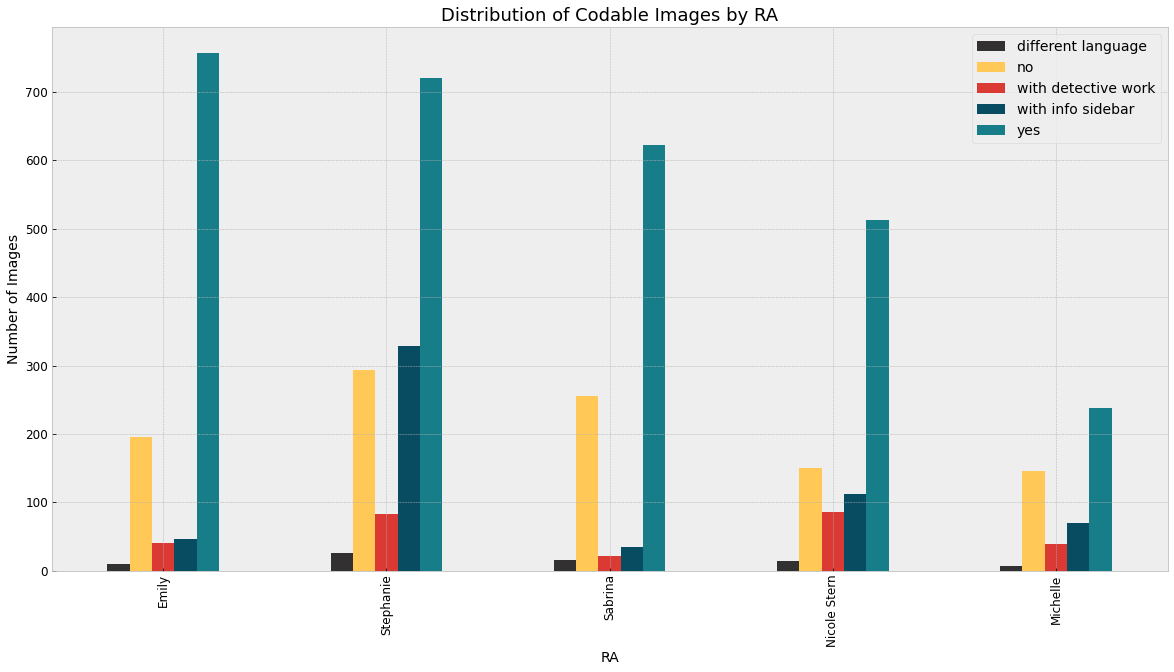

In [168]:
# create a bar chart for each ra where the x axis is the ra and the y axis shows the distribution of images
ra_batches = coded_images_df.groupby(['ra', 'identifiable'])
ra_batches = ra_batches['image'].count().unstack('identifiable').fillna(0)
ra_batches = ra_batches.sort_values(by=['yes'], ascending=False)

# set styles for the bar chart
plt.style.use('bmh')
colors = ['#323031', '#FFC857', '#DB3A34', '#084C61', '#177E89']
ax = ra_batches.plot.bar(stacked=False, figsize=(20, 10), color=colors)
ax.set_facecolor('#EEEEEE')
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)
ax.set_title('Distribution of Codable Images by RA', fontsize=18)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

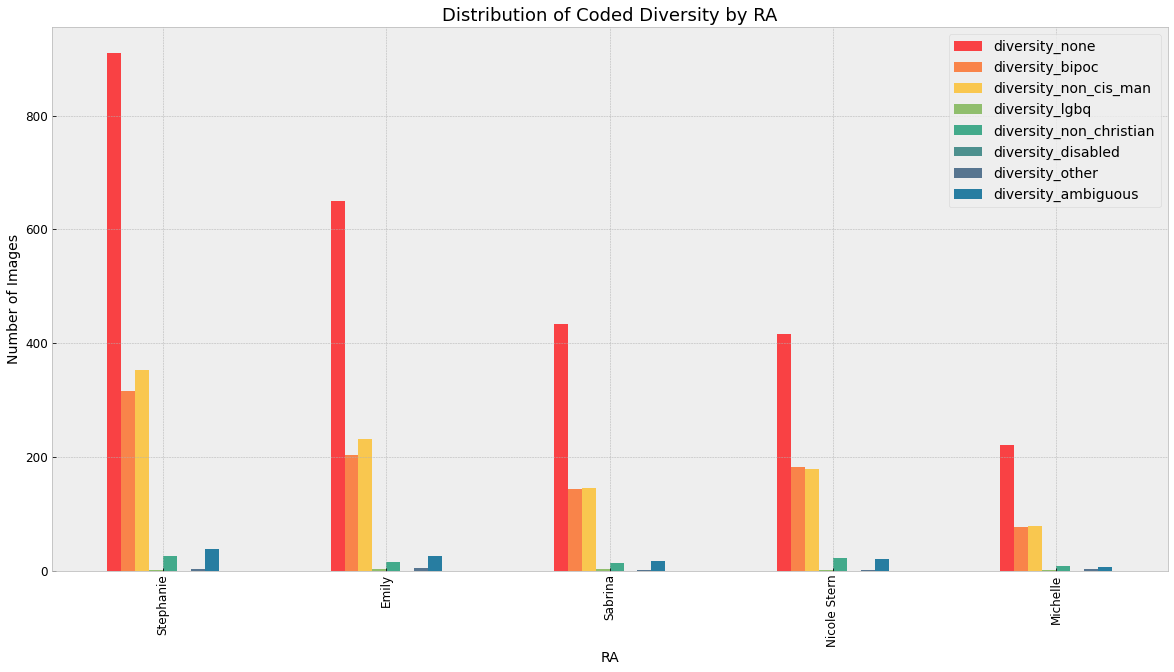

In [169]:
# create a bar chart for each ra where the x axis is the ra and the y axis shows the distribution of diversity categories
ra_batches = coded_images_df.groupby(['ra'])
# get counts for each diversity category
ra_batches = ra_batches[['diversity_none', 'diversity_bipoc', 'diversity_non_cis_man',
                        'diversity_lgbq', 'diversity_non_christian', 'diversity_disabled',
                        'diversity_other', 'diversity_ambiguous']].sum().fillna(0)

ra_batches = ra_batches.sort_values(by=['diversity_none'], ascending=False)


# set styles for the bar chart
plt.style.use('bmh')
colors = ['#f94144','#f9844a','#f9c74f','#90be6d','#43aa8b','#4d908e','#577590','#277da1']
ax = ra_batches.plot.bar(stacked=False, figsize=(20, 10), color=colors)
ax.set_facecolor('#EEEEEE')
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)
ax.set_title('Distribution of Coded Diversity by RA', fontsize=18)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


In [170]:
rebatching_df

,old_ra,old_batch,image,path
0,Emily,Batch 1 training set,user1433_1806_book_6_9.jpg,./coded-books\Emily\Batch 1 training set\user1...
1,Emily,Batch 1 training set,user1433_1806_book_7_10.jpg,./coded-books\Emily\Batch 1 training set\user1...
2,Emily,Batch 1 training set,user1436_577_book_1_5.jpg,./coded-books\Emily\Batch 1 training set\user1...
3,Emily,Batch 1 training set,user1446_3066_book_3_6.jpg,./coded-books\Emily\Batch 1 training set\user1...
4,Emily,Batch 1 training set,user1446_3066_book_7_10.jpg,./coded-books\Emily\Batch 1 training set\user1...
...,...,...,...,...
1362,Stephanie,Batch 36,user1913_4896_book_4_3.jpg,./coded-books\Stephanie\Batch 36\user1913_4896...
1363,Stephanie,Batch 36,user2446_73_book_2_2.jpg,./coded-books\Stephanie\Batch 36\user2446_73_b...
1364,Stephanie,Batch 36,user2669_1507_book_1_8.jpg,./coded-books\Stephanie\Batch 36\user2669_1507...
1365,Stephanie,Batch 36,user2958_156_book_2_1.jpg,./coded-books\Stephanie\Batch 36\user2958_156_...


## Batching

In [171]:
ra_batches_path = './coded-books'
output_path = './rebatched-12-21-2022'

batch_size = 100

"""
training_data = coded_images_df[coded_images_df['batch'].str.contains('training')]
non_training_data = coded_images_df[~coded_images_df['batch'].str.contains('training')]
"""

def create_path_from_row(row):
    return os.path.join(ra_batches_path, row['old_ra'], row['old_batch'], row['image'])

rebatching_df['path'] = rebatching_df.apply(lambda x: create_path_from_row(x), axis=1)
non_training_rebatching_images = rebatching_df[~rebatching_df['old_batch'].str.contains('training')]
training_rebatching_images = rebatching_df[rebatching_df['old_batch'].str.contains('training')]


# copy images to new directory
if not os.path.exists(output_path):
    os.mkdir(output_path)
# Group the images into directories by RA and make individual batches of size 100
ra_batches = non_training_rebatching_images.groupby(['old_ra'])
batch_no = 1
for ra, batch in ra_batches:
    ra_output_path = os.path.join(output_path, ra)
    if not os.path.exists(ra_output_path):
        os.mkdir(ra_output_path)
    for i in range(0, len(batch), batch_size):
        batch_output_path = os.path.join(ra_output_path, f'rebatch-{batch_no}')
        if not os.path.exists(batch_output_path):
            os.mkdir(batch_output_path)
        for index, row in batch[i:i+batch_size].iterrows():
            shutil.copy(row['path'], batch_output_path)

        batch_no += 1

# Rebatching training batches.
training_output_path = os.path.join(output_path, 'training')
if not os.path.exists(training_output_path):
    os.mkdir(training_output_path)
for i in range(0, len(training_rebatching_images), batch_size):
    batch_output_path = os.path.join(training_output_path, f'training-rebatch-{batch_no}')
    if not os.path.exists(batch_output_path):
        os.mkdir(batch_output_path)
    for index, row in training_rebatching_images[i:i+batch_size].iterrows():
        shutil.copy(row['path'], batch_output_path)

    batch_no += 1


